<a href="https://colab.research.google.com/gist/SK124/0ea3ce9ff3463f7d04deffe60929e75d/report-ucsd-200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Bird Classification

Dataset Used:Caltech-UCSD Birds 200 (CUB-200) 
It is an image dataset with photos of 200 bird species (mostly North American). 

Number of Categories: 200

Number of Images: 6,033

Annotations: Bounding Box, Rough Segmentation, Attributes
Since we are classsfying we can use only the images and lists files.

Images:648 MB

Lists: with class names, train/test splits, etc.

Usually every class had around 22-36 Images but data augmentation gave more data and decreased the influence of imbalance in data.

So lets move further and go through the different blocks in the notebook.

###Data Extracter Block

Extracting All the required Files.

###Package Imports Block

In [124]:
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import floor
import shutil
import random
print(os.listdir("./data"))

['classes.txt', '.DS_Store', 'images', 'datasets', 'train_test_split.txt', 'README', 'attributes', 'bounding_boxes.txt', 'parts', 'images.txt', 'image_class_labels.txt']


In [125]:
data_path='./data/datasets'
ROOT_DIR = './data'


In [126]:
from glob import glob

### Data preparation

In [127]:
orig_images_folder = 'images'
if os.path.exists('./data/datasets'):
  shutil.rmtree('./data/datasets')
else:
  new_images_folder = 'datasets'

  image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(ROOT_DIR, 'images.txt'),
                             header=None,
                             delimiter=' ',
                             nrows=543,
                             names=['Img ID', 'file path'])

  image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(ROOT_DIR, 'train_test_split.txt'),
                                                   header=None, delimiter=' ', nrows=543,
                                                   names=['Img ID', 'is training image?'])['is training image?']
  image_fnames.head()


In [128]:
if os.path.exists('./data/datasets'):
   shutil.rmtree('./data/datasets')

data_dir = os.path.join(ROOT_DIR, orig_images_folder)
new_data_dir = os.path.join(ROOT_DIR, new_images_folder)
os.makedirs(os.path.join(new_data_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir, 'test'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir, 'val'), exist_ok=True)

for i_image, image_fname in enumerate(image_fnames['file path']):
    if image_fnames['is training image?'].iloc[i_image]:
        new_dir = os.path.join(new_data_dir, 'train',
                               image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))
    else:
        new_dir = os.path.join(new_data_dir, 'test', image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))

        new_dir = os.path.join(new_data_dir, 'val', image_fname.split('/')[0])
        os.makedirs(new_dir, exist_ok=True)
        shutil.copy(src=os.path.join(data_dir, image_fname),
                    dst=os.path.join(new_dir, image_fname.split('/')[1]))

print('prepare dataset structure done.')


prepare dataset structure done.


### Dataviewer Block

Visualizing the Data:

In [130]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


In [131]:
img = mpimg.imread(
    './data/datasets/train/003.Sooty_Albatross/Sooty_Albatross_0001_1071.jpg')


In [132]:
type(img)


numpy.ndarray

In [133]:
img.shape


(500, 330, 3)

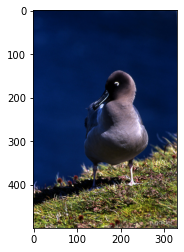

In [134]:
imgplot = plt.imshow(img)


In [135]:
def BirdView(genera):
  print("Samples images for Bird " + genera)
  root_path = './data/datasets/train/'
  img_path=root_path+genera+'/**'
  images =glob(img_path)
  plt.figure(figsize=(16,16))
  img=random.sample(images,3)
  plt.subplot(131)
  plt.imshow(cv2.imread(img[0]))
  plt.subplot(132)
  plt.imshow(cv2.imread(img[1]))
  plt.subplot(133)
  plt.imshow(cv2.imread(img[2]))
  return

Samples images for Bird 004.Groove_billed_Ani


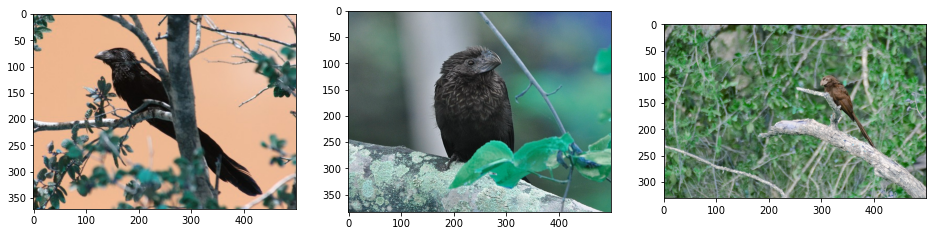

In [136]:
BirdView('004.Groove_billed_Ani')


In [137]:
print(os.listdir('./data/datasets/train'))


['005.Crested_Auklet', '010.Red_winged_Blackbird', '004.Groove_billed_Ani', '006.Least_Auklet', '009.Brewer_Blackbird', '002.Laysan_Albatross', '001.Black_footed_Albatross', '008.Rhinoceros_Auklet', '003.Sooty_Albatross', '007.Parakeet_Auklet']


"._"  files, these invisible files are "resource fork" segments of files that are being created on the external volume.
These were created after running the linux command


These cause the Datagenerator(os.listdir()) function loop to extract all files TWICE since both point to same file, took me a while to figure it out

So I wrote a function to remove such files


In [138]:
import glob


def delete_files(path, pattern):
    for f in glob.iglob(os.path.join(path, pattern)):
        try:
            os.remove(f)
        except OSError as exc:
            print (exc)

Note:Its optional to delete them, sometimes when you have limited data it is a uncommmon but useful practice to use dataset again as long as the model does not overfit it is applicable but be careful if you do so.

In [161]:
delete_files(data_path, '._**')

###Label Dictionary Block

So to label all the images during processing and augmentation ,we need a label dictionary to store all the labels, fortunately lists.txt has all classes and coressponding lables, with a simple python program we can exploit this text file to make a python dictionary instead of manually labelling all 200 classes

In [270]:
f = open('./data/classes.txt', 'r')
labels_dict = []
for line in f:
    v = ''.join(map(str,line.split('.')))
    k = line
    labels_dict[k.strip()] = int(''.join(map(str,v.strip())))

f.close()

ValueError: invalid literal for int() with base 10: '001Black_footed_Albatross'

In [273]:
label = pd.read_csv("./data/classes.txt", nrows=9)
print(label)

  001.Black_footed_Albatross
0       002.Laysan_Albatross
1        003.Sooty_Albatross
2      004.Groove_billed_Ani
3         005.Crested_Auklet
4           006.Least_Auklet
5        007.Parakeet_Auklet
6      008.Rhinoceros_Auklet
7       009.Brewer_Blackbird
8   010.Red_winged_Blackbird


As you can see it stores all the classes and the labels

Take Note that indexing starts from 1 instead of 0 which would be ideal if you use keras's inbuit .to_categorical utility
You can easily do that by making the following change



         labels_dict[k.strip()] = int(v.strip())-1
But it doesnt have any adverse affects, it only increases the columns of one hot encoded labels which I will explain in a moment


In [272]:
label


,001.Black_footed_Albatross
0,002.Laysan_Albatross
1,003.Sooty_Albatross
2,004.Groove_billed_Ani
3,005.Crested_Auklet
4,006.Least_Auklet
5,007.Parakeet_Auklet
6,008.Rhinoceros_Auklet
7,009.Brewer_Blackbird
8,010.Red_winged_Blackbird


###Dataloader Block

This Block does the Following:

1.Resizes the image to array of  required size, it uses cv2.INTER_AREA interpolation which is better than other techniques. You can also try cv2.INTER_CUBIC which will keep the features of image constant but crashes colab's memory at size=(256,256) due to complexity of its(cv2.INTER_CUBIC) algorithm


2.Augments the data by flipping 

3.Converts labels to Onehot-Encoded Form
 
Now I create two lists to store images and corresponding labels,
strip function is to remove all the ._ images which we do not want as they are redundant as we process the image we store it in the list and also the labels in its list.
Then we convert image into np.array and labels to to.categorical which makes the labels into one hot encoded form as we are dealing with a multi class classification problem


Then we split the data in following ratio:

X_train=70% 

X_Test=20%

 X_valid=10% 

 You can also follow your own splitting criteria.


In [258]:
def load_data():
  #Loads data and preprocesses it,returns train an test data along with labels
  images=[]
  labels=[]
  
  size=(64,64)
  print('Loaing Data from File ',end='')
  for folder in os.listdir(data_path):
    fol=folder.strip('._')
    path= data_path +  '/' + fol
    print(fol,end='|')
    for image in os.listdir(path):
      if(image != ".DS_Store"):
        try:
          temp_img=cv2.imread(path+'/'+image)
          temp_img=cv2.resize(temp_img,size,interpolation=cv2.INTER_AREA)
          images.append(temp_img)
          labels.append(label[fol])
          temp_img=cv2.flip(temp_img,flipCode=1)
          images.append(temp_img)
          labels.append(label[fol])
        except Exception :
          pass
  images=np.array(images)
  images=images.astype('float32')/255.0
  labels=keras.utils.np_utils.to_categorical(labels)
  X_train,X_test,y_train,y_test=train_test_split(images,labels,test_size=0.2)
  print()
  print('Loaded',len(X_train),' images for training','Train data shape ',X_train.shape)
  print('Loaded',len(X_test),' images for testing','Test data shape ',X_test.shape)

  return X_train,X_test,y_train,y_test

In [267]:
X_train,X_test,y_train,y_test=load_data()

Loaing Data from File test|train|val|

ValueError: zero-size array to reduction operation maximum which has no identity

I did try both sizes (64X64) and (128X128) and from my observation they perfrom somewhat similar even though 128X128 size arrays are a bit clearer to interpret to an Human Eye.

Size=64X64

In [186]:
plt.imshow(X_train[12,:,:])
plt.show()

NameError: name 'X_train' is not defined

Size=128X128

In [187]:
plt.imshow(X_train[2101,:,:])
plt.show()

NameError: name 'X_train' is not defined

###CNN Architecture Block

CUSTOM CNN:

This architecture performed consideraby better than other architectures I experimented.

In [ ]:
def create_model():
    model=Sequential()
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(Dense(201, activation = 'softmax'))
    model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
    
    print('Model Created')
    model.summary()
    return model

def fit_model():
  model_hist=model.fit(X_train,y_train,batch_size=64,epochs=25,validation_split=0.125)
  return model_hist

You can see the last fully connected layer has 201 columns,this is because of the way we labelled the images , keras.to_categorical adds 1 to the number of classes,therefore  200+1= hence 201.

Taken from Keras documentation

Link: https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py

        num_classes = np.max(y) + 1
        n = y.shape[0]
        categorical = np.zeros((n, num_classes), dtype=dtype)
        categorical[np.arange(n), y] = 1



   


So in our y_train(one Hot Encoded) we will see that the first column has no values at all beacuse we didnt start labelling with 0 we did it with 1.
As you can see there are no labels in the 1st column.Maximum value in this column is 0 which means no label is being stored.
Hope this ambuigity is clear.

You can also change the way you label but the results will remain identical.

In [ ]:
z=y_train[:,0];np.max(z)

0.0

In [ ]:
z=y_train[:,200];np.max(z)

1.0

 Key Takeaways:

 1.You can see 201 is out of bounds, which means labels starts from 0 and ends at 200 

 2.In our case Label 0 has no image of its kind becuse there are no images of its kind this is the way we constructed our label_dict dictionary.

In [ ]:
z=y_train[:,201];np.max(z)

IndexError: ignored

###Training Block

In [ ]:
model=create_model()
curr_model_hist=fit_model()

Model Created
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 7, 

In [ ]:
model.save_weights('83.55.h5')

In the bottom cells I let the model train and checked the result every 25 epochs and saved after every such iteration.

In [ ]:
curr_model_hist=fit_model()

In [ ]:
model.save_weights('weights_88.32')
model.save('88.32')

In [ ]:
curr_model_hist=fit_model()

In [ ]:
curr_model_hist=fit_model()

In [ ]:
model.save_weights('weights_89.48.h5')
model.save('model_89.48.h5')

In [ ]:
curr_model_hist=fit_model()

Train on 16891 samples, validate on 2414 samples
Epoch 1/25
16891/16891 [==============================] - 10s 601us/step - loss: 0.6152 - acc: 0.9480 - val_loss: 1.0403 - val_acc: 0.8836
Epoch 2/25
16891/16891 [==============================] - 10s 593us/step - loss: 0.5991 - acc: 0.9528 - val_loss: 0.9600 - val_acc: 0.8964
Epoch 3/25
16891/16891 [==============================] - 10s 592us/step - loss: 0.6067 - acc: 0.9500 - val_loss: 0.9734 - val_acc: 0.8861
Epoch 4/25
16891/16891 [==============================] - 10s 596us/step - loss: 0.6096 - acc: 0.9516 - val_loss: 0.9726 - val_acc: 0.8956
Epoch 5/25
16891/16891 [==============================] - 10s 592us/step - loss: 0.5864 - acc: 0.9577 - val_loss: 0.9542 - val_acc: 0.8923
Epoch 6/25
16891/16891 [==============================] - 10s 597us/step - loss: 0.5902 - acc: 0.9529 - val_loss: 0.9565 - val_acc: 0.8956
Epoch 7/25
16891/16891 [==============================] - 10s 595us/step - loss: 0.5848 - acc: 0.9560 - val_loss: 1.0

In [ ]:
model.save("weights_8877.48.h5")

### Evaluation Block

Evaluation on Test Set

In [ ]:
evaluate_metrics=model.evaluate(X_test,y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluatation Loss = ","{:.6f}%".format(evaluate_metrics[0]))

4827/4827 [==============================] - 1s 308us/step

Evaluation Accuracy =  88.56% 
Evaluatation Loss =  1.040152%


###Miscellaneous Block

Saving the model to disk

In [ ]:
model.save(' best_model.h5')
model.save_weights(' best_weights')

In [ ]:
model.save_weights(' best_weights.h5')

In [ ]:
model.save_weights(' best_weights')

In [ ]:
model_yaml = model.to_yaml()
with open(" best_model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
print("Saved model to disk")

Saved model to disk


###Perfomance of 128X128 Images

For this model I changed the image size to 128X128 to check if it gets any better accuracy actually it did not.
Actually it looks like it overfits on training data but we can see valid accuracy is not decreasing but neither increasing.
It seems like it got stuck in a local minima.

Training it any longer maynot improve the perfomance so I stopped training it.
In other notebooks where I experimented **occasionally** it(128X128) produced similar results as size 64X64 one by careful regularization but it's not as stable as 64X64. 

In [ ]:
model=create_model()
curr_model_hist=fit_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)       

Saved the test set to disk and put into new folder called 'utils' where I also put save model and weight and uploaded it to the drive for later use.

####Saving Deleiverables to Drive

In [ ]:
np.save(' X_test',X_test)

In [ ]:
np.save(' y_test',y_test)

In [ ]:
mkdir utils

In [ ]:
mv /content/' X_test.npy' /content/utils

In [ ]:
mv  /content/' y_test.npy' /content/utils

In [ ]:
mv  /content/' best_model.h5' /content/utils

In [ ]:
mv  /content/' best_weights.h5' /content/utils

In [ ]:
mv  /content/' best_weights' /content/utils

In [ ]:
mv /content/' best_model.yaml'  /content/utils

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Zipping and Loading to Drive

In [ ]:
!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

zipname = 'delieverables'

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])

zipfolder(zipname, '/content/utils/')

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Create & upload a file text file.
file1 = drive.CreateFile()
file1.SetContentFile(zipname+".zip")
file1.Upload()

###Summary and Perfomance of other architectures

As the required accuracy was to be more than 95% I tried out few more exisiting architectures like Resnet18, Resnet50, Vggn16 unfortunaley I could not get any desired accuracy infact lower,maybe because the dataset we were dealing with this too small for big architecures.
 
For these architecture's implementations I used fast.ai library 
I augmented the data to avoid overfitting as much as possible using fast.ai Imagelist 

Results:

Vggn16 with batchnorm : Maximum accuracy of 39%
accuracy kept on oscillating back and forth but did not move above 39%

Resnet18: It also did not perform well,got an mere accuracy of 20% and did not converge any further,image size was changed to as described in paper to fit the model

Resnet 50 : It got an accuracy of about 70% but then it did not improve any further.

Suggestions and Questions are Welcome!